# **PROJET 6** : Analysez les ventes d'une librairie avec Python
---

**Mise en situation** 

L’entreprise Lapage était originellement une librairie physique avec plusieurs points de vente. Mais devant le succès de certains de ses produits et l’engouement de ses clients, elle a décidé depuis 2 ans d’ouvrir un site de vente en ligne. La structure a besoin d’aide pour mieux comprendre ses données, c’est pourquoi elle vous a recruté. Vous intervenez en tant que Data Analyst afin de faire le point sur l’activité.

**Consignes**
- Analyses des indicateurs de ventes : les chiffres clés, KPI, graphiques générés, etc. 
- Analyse des corrélations

**Compétences évaluées**
- Réaliser un test statistique
- Réaliser une analyse bivariée pour interpréter des données
- Analyser des séries temporelles

## Sommaire
---

- [**Section 1: Import**](#section1)
- [**Section 2: Jointures**](#section2)
- [**Section 3: Manipulation DFT**](#section3)
- [**Section 4: Etude du CA**](#section4)
- [**Section 5: Correlations**](#section5)
- [**Section 6: Conclusion**](#section6)
---


<a id="section1"></a>
# **IMPORT**
---

In [361]:
# import des modules et des packages

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import statsmodels.api as sm
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from scipy.stats import linregress

In [362]:
def etude_fichier(df):
    # Etude du fichier 
    print("Nombre de colonnes :", df.shape)
    print()
    print("Le type est : \n", df.dtypes)
    print()
    print('Nombre de unique')
    print(df.nunique())
    print()
    print('le nombre de null est :\n',df.isnull().sum())

In [363]:
#Import fichiers csv
customers = pd.read_csv('customersv2.csv', delimiter=';')
transactions = pd.read_csv('Transactionsv2.csv',delimiter=';')
products = pd.read_csv('productsv2.csv',delimiter=';')

## customers

In [364]:
customers.head()

,52,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


In [365]:
etude_fichier(customers)

Nombre de colonnes : (8621, 3)

Le type est : 
 52       object
sex      object
birth     int64
dtype: object

Nombre de unique
52       8621
sex         2
birth      76
dtype: int64

le nombre de null est :
 52       0
sex      0
birth    0
dtype: int64


In [366]:
# ajout d'un entête pour la colonne id
customers.rename(columns={'52' : 'client_id'}, inplace=True)

## transactions

In [367]:
transactions.head()

,id_prod,date,session_id,client_id
0,0_1259,2021-03-01 00:01:07.843138,s_1,c_329
1,0_1390,2021-03-01 00:02:26.047414,s_2,c_664
2,0_1352,2021-03-01 00:02:38.311413,s_3,c_580
3,0_1458,2021-03-01 00:04:54.559692,s_4,c_7912
4,0_1358,2021-03-01 00:05:18.801198,s_5,c_2033


In [368]:
etude_fichier(transactions)

Nombre de colonnes : (687534, 4)

Le type est : 
 id_prod       object
date          object
session_id    object
client_id     object
dtype: object

Nombre de unique
id_prod         3265
date          687419
session_id    345505
client_id       8600
dtype: int64

le nombre de null est :
 id_prod       0
date          0
session_id    0
client_id     0
dtype: int64


## products

In [369]:
products.head()

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


In [370]:
etude_fichier(products)

Nombre de colonnes : (3286, 3)

Le type est : 
 id_prod     object
price      float64
categ        int64
dtype: object

Nombre de unique
id_prod    3286
price      1454
categ         3
dtype: int64

le nombre de null est :
 id_prod    0
price      0
categ      0
dtype: int64


<a id="section2"></a>
# **JOINTURES**
---

## jointures en partant du fichier products

In [371]:
df = pd.merge( products,transactions, on='id_prod', how='left')
etude_fichier(df)

Nombre de colonnes : (687555, 6)

Le type est : 
 id_prod        object
price         float64
categ           int64
date           object
session_id     object
client_id      object
dtype: object

Nombre de unique


id_prod         3286
price           1454
categ              3
date          687419
session_id    345505
client_id       8600
dtype: int64

le nombre de null est :
 id_prod        0
price          0
categ          0
date          21
session_id    21
client_id     21
dtype: int64


In [372]:
# test de Liaison entre les pordutis et les transactions 
left = pd.merge(products, transactions, on='id_prod', how='left')
nb_left = left['id_prod'].nunique()

# test de Liaison entre les pordutis et les transactions 
right = pd.merge(products, transactions, on='id_prod', how='right')
nb_right = right['id_prod'].nunique()

In [373]:
nb_left - nb_right
# on garde le left car dans le right on ne garde pas les produits qui n'otn pas de transactiosn

21

In [374]:
nb_left

3286

In [375]:
# Liaison entre df et les clients
dft = pd.merge(left, customers, on='client_id',how='left')
etude_fichier(dft)

Nombre de colonnes : (687555, 8)

Le type est : 
 id_prod        object
price         float64
categ           int64
date           object
session_id     object
client_id      object
sex            object
birth         float64
dtype: object

Nombre de unique
id_prod         3286
price           1454
categ              3
date          687419
session_id    345505
client_id       8600
sex                2
birth             76
dtype: int64

le nombre de null est :
 id_prod        0
price          0
categ          0
date          21
session_id    21
client_id     21
sex           21
birth         21
dtype: int64


In [376]:
dft.describe(include='all')

,id_prod,price,categ,date,session_id,client_id,sex,birth
count,687555,687555.000000,687555.000000,687534,687534,687534,687534,687534.000000
unique,3286,NaN,NaN,687419,345505,8600,2,NaN
top,1_369,NaN,NaN,2021-10-08 22:53:39.537131,s_118668,c_1609,m,NaN
freq,2340,NaN,NaN,2,14,25586,344841,NaN
mean,NaN,17.494540,0.448787,NaN,NaN,NaN,NaN,1977.817391
std,NaN,18.240963,0.594567,NaN,NaN,NaN,NaN,13.607935
min,NaN,0.620000,0.000000,NaN,NaN,NaN,NaN,1929.000000
25%,NaN,8.990000,0.000000,NaN,NaN,NaN,NaN,1970.000000
50%,NaN,13.990000,0.000000,NaN,NaN,NaN,NaN,1980.000000
75%,NaN,19.080000,1.000000,NaN,NaN,NaN,NaN,1987.000000


21 ligne n'ont pas de correspondnce avec cette méthode, essayont de partir du fichier transactions et rattacher les correspondance.
Cela peut correspondre à des produits de notre catalogue qui n'ont pas eu de ventes sur la période.

## jointure en partant du fichier transactions

In [377]:
df = pd.merge(transactions, products, on='id_prod', how='left')
etude_fichier(df)

Nombre de colonnes : (687534, 6)

Le type est : 
 id_prod        object
date           object
session_id     object
client_id      object
price         float64
categ           int64
dtype: object

Nombre de unique
id_prod         3265
date          687419
session_id    345505
client_id       8600
price           1442
categ              3
dtype: int64

le nombre de null est :
 id_prod       0
date          0
session_id    0
client_id     0
price         0
categ         0
dtype: int64


Je n'ai plus de Nulls dans ce sens la Mais j'ai moins d'id_prod que dans ma première jointure

In [378]:
test = pd.merge(df, customers, on='client_id', how='left')
etude_fichier(test)

Nombre de colonnes : (687534, 8)

Le type est : 
 id_prod        object
date           object
session_id     object
client_id      object
price         float64
categ           int64
sex            object
birth           int64
dtype: object

Nombre de unique
id_prod         3265
date          687419
session_id    345505
client_id       8600
price           1442
categ              3
sex                2
birth             76
dtype: int64

le nombre de null est :
 id_prod       0
date          0
session_id    0
client_id     0
price         0
categ         0
sex           0
birth         0
dtype: int64


Toutes mes lignes ont des correspondances, le dataframe dft ne contient pas nos produits sans ventes, donc il manque des données qui peuvent être importante dans notre analyse. On va donc garder l'autre type de liaison.

<a id="section3"></a>
# **MANIPULATION DFT**
---

## Etude DFT

In [379]:
dft.head()

,id_prod,price,categ,date,session_id,client_id,sex,birth
0,0_1421,19.99,0,2021-03-01 04:13:00.107748,s_101,c_8533,m,1972.0
1,0_1421,19.99,0,2021-03-01 13:48:20.214075,s_285,c_5299,f,1967.0
2,0_1421,19.99,0,2021-03-01 15:07:42.730079,s_317,c_8024,f,1936.0
3,0_1421,19.99,0,2021-03-02 03:39:21.811833,s_563,c_7702,f,1989.0
4,0_1421,19.99,0,2021-03-02 19:09:41.789425,s_850,c_4057,m,1981.0


In [380]:
etude_fichier(dft)

Nombre de colonnes : (687555, 8)

Le type est : 
 id_prod        object
price         float64
categ           int64
date           object
session_id     object
client_id      object
sex            object
birth         float64
dtype: object

Nombre de unique
id_prod         3286
price           1454
categ              3
date          687419
session_id    345505
client_id       8600
sex                2
birth             76
dtype: int64

le nombre de null est :
 id_prod        0
price          0
categ          0
date          21
session_id    21
client_id     21
sex           21
birth         21
dtype: int64


## Modifications DFT

In [381]:
# Conversion de la colonne "birth" en format année
dft['birth'] = pd.to_numeric(dft['birth'], errors='coerce').astype(pd.Int64Dtype()) # Convertir en type entier

# Convertir la colonne "date" en format de date
dft['date'] = pd.to_datetime(dft['date'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')

# Calcul de l'âge
current_year = datetime.now().year
dft['age'] = current_year - dft['birth']

In [382]:
# Définition des intervalles d'âge
intervalles = [0, 18, 30, 40, 50, 60, 70, float('inf')]
tranche = ['0-18', '19-30', '31-40', '41-50', '51-60', '61-70', '70+']

# Création de la colonne "age_group" avec les tranches d'âge
dft['tranche'] = pd.cut(dft['age'], bins=intervalles, labels=tranche, right=False)

In [383]:
# Conversion de l'age en int
dft['age'] = pd.to_numeric(dft['age'], errors='coerce')

# Conversion de categ en string
dft['categ'] = dft['categ'].astype(str)

In [384]:
# pour l'attribution des profils je dois me débarsser des nuls qui crée des erreur dans la fonction assign profile
dft.dropna(subset=['age', 'sex'], inplace=True)

In [385]:
def assign_profile(row):
    age = row['age']
    sex = row['sex']

    # Définir la tranche d'âge
    if age < 18:
        tranche = '0-18'
    elif age < 30:
        tranche = '18-30'
    elif age < 40:
        tranche = '30-40'
    elif age < 50:
        tranche = '40-50'
    elif age < 60:
        tranche = '50-60'
    elif age < 70:
        tranche = '60-70'
    else:
        tranche = '70+'

    # Définir le profil en combinant le sexe et la tranche d'âge
    if sex == 'm':
        profil = 'Homme'
    else:
        profil = 'Femme'

    return profil + ' entre ' + tranche + ' ans'

# Appliquer la fonction d'assignation de profil à chaque ligne du DataFrame
dft['profil'] = dft.apply(assign_profile, axis=1)

In [386]:
# Calculer le panier moyen par âge
panier_moyen_par_age = dft.groupby('age')['price'].mean().reset_index(name='panier_moyen_par_age')

# Joindre cette information à votre dataframe original
dft = dft.merge(panier_moyen_par_age, on='age', how='left')

In [387]:
dft.head()

,id_prod,price,categ,date,session_id,client_id,sex,birth,age,tranche,profil,panier_moyen_par_age
0,0_1421,19.99,0,2021-03-01 04:13:00.107748,s_101,c_8533,m,1972,51,51-60,Homme entre 50-60 ans,13.370291
1,0_1421,19.99,0,2021-03-01 13:48:20.214075,s_285,c_5299,f,1967,56,51-60,Femme entre 50-60 ans,16.806677
2,0_1421,19.99,0,2021-03-01 15:07:42.730079,s_317,c_8024,f,1936,87,70+,Femme entre 70+ ans,16.850812
3,0_1421,19.99,0,2021-03-02 03:39:21.811833,s_563,c_7702,f,1989,34,31-40,Femme entre 30-40 ans,13.370611
4,0_1421,19.99,0,2021-03-02 19:09:41.789425,s_850,c_4057,m,1981,42,41-50,Homme entre 40-50 ans,13.352637


In [388]:
# Calculer le panier moyen par tranche d'age
panier_moyen_par_tranche_age = dft.groupby('tranche')['price'].mean().reset_index(name='panier_moyen_par_tranche_age')

# Joindre cette information à votre dataframe original
dft = dft.merge(panier_moyen_par_tranche_age, on='tranche', how='left')

In [389]:
# Calculer la fréquence d'achat pour chaque client
frequence_achat = dft.groupby('client_id').size().reset_index(name='frequence_achat')

# Joindre cette information à votre dataframe original
dft = dft.merge(frequence_achat, on='client_id', how='left')

In [390]:
dft.head()

,id_prod,price,categ,date,session_id,client_id,sex,birth,age,tranche,profil,panier_moyen_par_age,panier_moyen_par_tranche_age,frequence_achat
0,0_1421,19.99,0,2021-03-01 04:13:00.107748,s_101,c_8533,m,1972,51,51-60,Homme entre 50-60 ans,13.370291,15.857667,51
1,0_1421,19.99,0,2021-03-01 13:48:20.214075,s_285,c_5299,f,1967,56,51-60,Femme entre 50-60 ans,16.806677,15.857667,62
2,0_1421,19.99,0,2021-03-01 15:07:42.730079,s_317,c_8024,f,1936,87,70+,Femme entre 70+ ans,16.850812,16.724476,105
3,0_1421,19.99,0,2021-03-02 03:39:21.811833,s_563,c_7702,f,1989,34,31-40,Femme entre 30-40 ans,13.370611,14.947460,94
4,0_1421,19.99,0,2021-03-02 19:09:41.789425,s_850,c_4057,m,1981,42,41-50,Homme entre 40-50 ans,13.352637,13.251897,243


In [391]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 687534 entries, 0 to 687533
Data columns (total 14 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   id_prod                       687534 non-null  object        
 1   price                         687534 non-null  float64       
 2   categ                         687534 non-null  object        
 3   date                          687298 non-null  datetime64[ns]
 4   session_id                    687534 non-null  object        
 5   client_id                     687534 non-null  object        
 6   sex                           687534 non-null  object        
 7   birth                         687534 non-null  Int64         
 8   age                           687534 non-null  Int64         
 9   tranche                       687534 non-null  category      
 10  profil                        687534 non-null  object        
 11  panier_moyen_

Nous avosn toutes les colonnes qui nous eeront nécessaires pour faire les analyses demandées. L'age des clients, leurs profils ainsi qu'une tranche d'age.

<a id="section4"></a>
# **ETUDE DU CA**
---

##  Evolution dans le temps et  décomposition en moyenne mobile pour évaluer la tendance golbale

In [392]:
# Regrouper les données par mois et calculer le chiffre d'affaires total par mois
vente_mois = dft.groupby(pd.Grouper(key='date', freq='M')).sum()['price']
vente_mois.head()

date
2021-03-31    482440.61
2021-04-30    476109.30
2021-05-31    492943.47
2021-06-30    484088.56
2021-07-31    482835.40
Name: price, dtype: float64

In [393]:
# Calcul de la moyenne mobile avec une fenêtre de 3

'''La moyenne mobile est une méthode couramment utilisée pour lisser les fluctuations temporaires dans les séries de données
En d'autres termes, elle aide à éliminer le "bruit" et à mettre en évidence la tendance sous-jacente.

La "fenêtre" est le nombre de périodes de temps sur lesquelles la moyenne est calculée.
Ici, nous utilisons une fenêtre de 3, ce qui signifie que nous calculons la moyenne des ventes pour chaque groupe de 3 mois consécutifs.

vente_mois.rolling(window=3).mean() crée une nouvelle série de données où chaque point est la moyenne des ventes des 3 mois précédents.
#Note : Les deux premiers points de la série de la moyenne mobile seront NaN parce qu'ils n'ont pas deux mois précédents sur lesquels calculer une moyenne.'''
rolling_mean = vente_mois.rolling(window=3).mean()


In [394]:
# Calcul de la régression linéaire pour la tendance

'''Utiliser la régression linéaire pour trouver la meilleure ligne droite qui s'adapte aux données de vente mensuelles
Les valeurs x sont les indices des mois (0, 1, 2, ...) et les valeurs y sont les ventes mensuelles'''
slope, intercept, r_value, p_value, std_err = linregress(range(len(vente_mois)), vente_mois.values)

'''Calcul de la ligne de tendance (y = mx + b) en utilisant la pente (m) et l'ordonnée à l'origine (b) calculées précédemment
La liste "trendline" contient les valeurs y de la ligne de tendance pour chaque mois'''
trendline = [slope * x + intercept for x in range(len(vente_mois))]

# "slope" est la pente de la ligne, représentant le taux de changement des ventes par mois
# "intercept" est l'ordonnée à l'origine, représentant la valeur de départ des ventes
# "r_value" est le coefficient de corrélation, indiquant la force et la direction de la relation linéaire
# "p_value" est la valeur-p, utilisée pour tester l'hypothèse nulle que la pente est nulle
# "std_err" est l'erreur standard de l'estimation de la pente

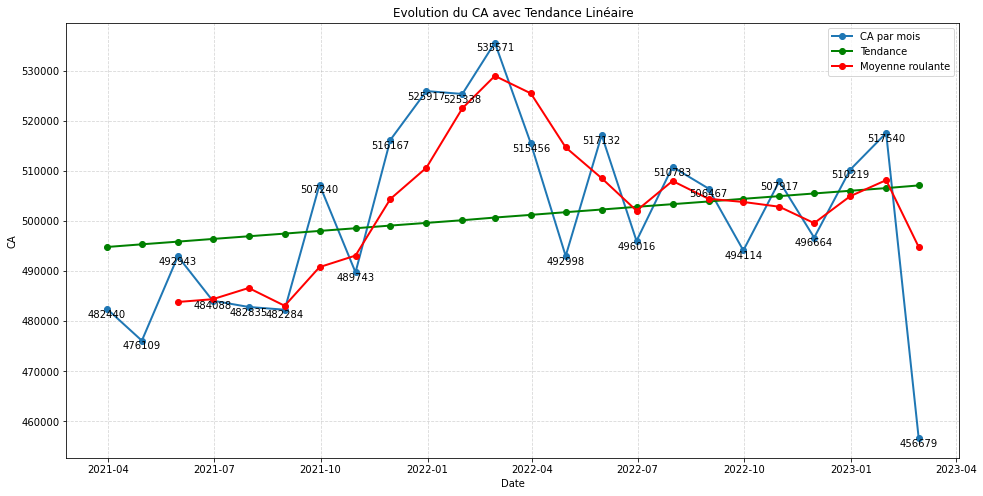

In [395]:
plt.figure(figsize=(16, 8))

# Affichage des données
plt.plot(vente_mois.index, vente_mois.values, label='CA par mois', marker='o', linewidth=2)
plt.plot(vente_mois.index, trendline, label='Tendance', color='green', marker='o', linewidth=2)
plt.plot(vente_mois.index, rolling_mean, label='Moyenne roulante', color='red', marker='o', linewidth=2)

# Ajouter les étiquettes de valeurs en dessous des coordonnées de chaque point
for i, value in enumerate(vente_mois.values):
    plt.text(vente_mois.index[i], value - 70, f"{int(value)}", ha='center', va='top', fontsize=10)

# Ajouter une grille
plt.grid(True, linestyle='--', alpha=0.5)

# ajouter les titres des axes
plt.title('Evolution du CA avec Tendance Linéaire')
plt.xlabel('Date')
plt.ylabel('CA')
plt.legend()
plt.show()

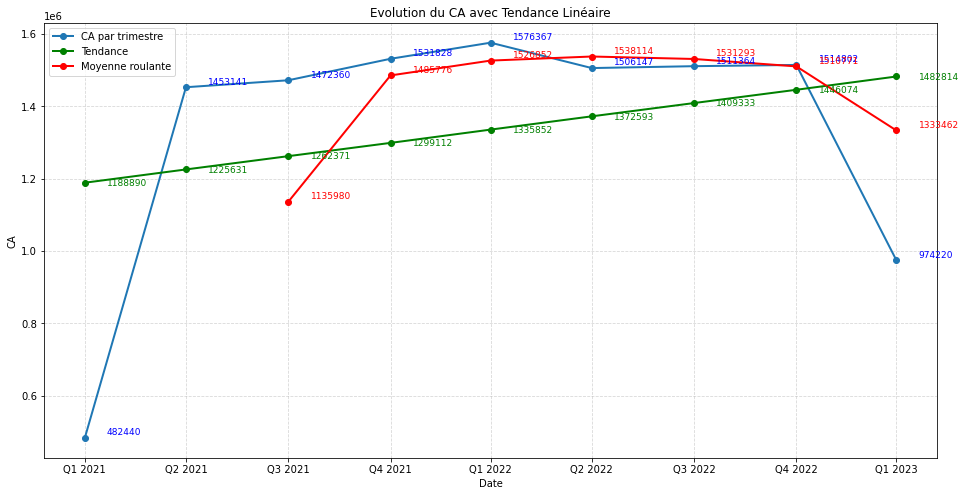

In [396]:
# Résample les données par trimestre
vente_trimestre = vente_mois.resample('Q').sum()

# Calcul de la régression linéaire pour la tendance
slope, intercept, r_value, p_value, std_err = linregress(range(len(vente_trimestre)), vente_trimestre.values)
trendline = [slope * x + intercept for x in range(len(vente_trimestre))]

# Calcul de la moyenne roulante avec une fenêtre de 3
rolling_mean = vente_trimestre.rolling(window=3).mean()

plt.figure(figsize=(16, 8))

# Affichage des données
plt.plot(vente_trimestre.index, vente_trimestre.values, label='CA par trimestre', marker='o', linewidth=2)
plt.plot(vente_trimestre.index, trendline, label='Tendance', color='green', marker='o', linewidth=2)
plt.plot(vente_trimestre.index, rolling_mean, label='Moyenne roulante', color='red', marker='o', linewidth=2)

# Ajout d'une grille
plt.grid(True, linestyle='--', alpha=0.5)

# Ajout des titres des axes
plt.title('Evolution du CA avec Tendance Linéaire')
plt.xlabel('Date')
plt.ylabel('CA')

# Création des étiquettes de trimestre
quarter_labels = []
for date in vente_trimestre.index:
    quarter = (date.month - 1) // 3 + 1
    quarter_labels.append(f'Q{quarter} {date.year}')

x_offset = pd.Timedelta(days=20)  # Décalage horizontal en jours
y_offset = 8000  # Décalage vertical

# Ajout des valeurs de chaque point pour le CA par trimestre
for i, value in enumerate(vente_trimestre.values):
    plt.text(vente_trimestre.index[i] + x_offset, value + y_offset, f"{int(value)}", fontsize=9, color='blue')

# Ajout des valeurs de chaque point pour la tendance
for i, value in enumerate(trendline):
    plt.text(vente_trimestre.index[i] + x_offset, value - y_offset, f"{int(value)}", fontsize=9, color='green')

# Ajout des valeurs de chaque point pour la moyenne roulante
for i, value in enumerate(rolling_mean.dropna().values):
    plt.text(rolling_mean.dropna().index[i] + x_offset, value + y_offset, f"{int(value)}", fontsize=9, color='red')
plt.xticks(vente_trimestre.index, quarter_labels)

plt.legend()
plt.show()

##  Zoom sur les réfrences pour voir top et flop

### Références les plus vendues et moins vendues en nombre de ventes

In [397]:
# Comparer les colonnes 'id_product' des deux DataFrames
# 'isin' renvoie un masque booléen, True pour les valeurs présentes dans 'products' mais absentes dans 'dft'
produit_sans_ventes = products[~products['id_prod'].isin(dft['id_prod'])]

# Afficher les valeurs absentes
print(produit_sans_ventes)

     id_prod   price  categ
184   0_1016   35.06      0
279   0_1780    1.67      0
736   0_1062   20.08      0
793   0_1119    2.99      0
810   0_1014    1.15      0
845      1_0   31.82      1
1030  0_1318   20.92      0
1138  0_1800   22.05      0
1346  0_1645    2.99      0
1504   0_322    2.99      0
1529  0_1620    0.80      0
1542  0_1025   24.99      0
1708    2_87  220.99      2
1862   1_394   39.73      1
1945    2_72  141.32      2
2214   0_310    1.94      0
2407  0_1624   24.50      0
2524    2_86  132.36      2
2689   0_299   22.99      0
3030   0_510   23.66      0
3095  0_2308   20.28      0


In [398]:
# Grouper par 'id_prod' et compter le nombre de ventes pour chaque référence
ventes_par_reference = dft['id_prod'].value_counts()

# Tri décroissant pour les références les plus vendues
references_plus_vendues = ventes_par_reference.sort_values(ascending=False)

# Affichage des références les plus vendues (les 10 premières lignes)
print("Références les plus vendues:")
print(references_plus_vendues.head(10))


Références les plus vendues:
1_369    2340
1_417    2269
1_414    2246
1_498    2202
1_425    2163
1_403    2040
1_413    2036
1_412    2014
1_406    2003
1_407    2001
Name: id_prod, dtype: int64


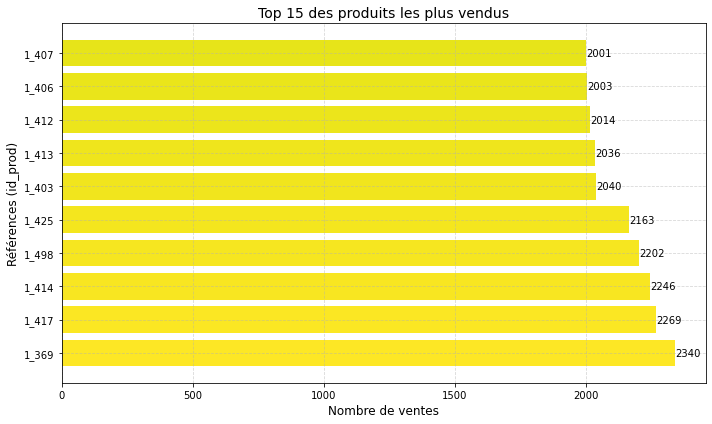

In [399]:
# Tracer le graphique en barres horizontales pour les références les plus vendues (top 15)
plt.figure(figsize=(10, 6))

# Utilisation de barh pour les barres horizontales
bar_colors = plt.cm.get_cmap('viridis_r')(range(len(references_plus_vendues.head(10).index)))
plt.barh(references_plus_vendues.head(10).index, references_plus_vendues.head(10).values, color=bar_colors)

# Ajouter des étiquettes de valeur à droite de chaque barre
for i, value in enumerate(references_plus_vendues.head(10).values):
    plt.text(value + 1, i, f"{value}", va='center')

# Personnaliser l'apparence du graphique
plt.xlabel('Nombre de ventes', fontsize=12)
plt.ylabel('Références (id_prod)', fontsize=12)
plt.title('Top 15 des produits les plus vendus', fontsize=14)
plt.xticks(fontsize=10)
plt.tight_layout()

# Ajout d'une grille
plt.grid(True, linestyle='--', alpha=0.5)

# Afficher le graphique
plt.show()


### Références les plus vendus en CA

In [400]:
# Les références les plus vendues (top)
top_references = dft.groupby('id_prod').sum()['price'].nlargest(10)

# Trier les références par ordre décroissant
top_references_sorted = top_references.sort_values(ascending=True)

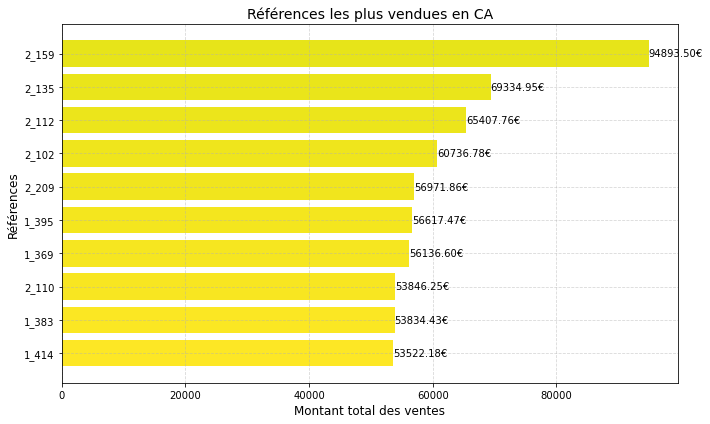

In [401]:
plt.figure(figsize=(10, 6))

# Tracer le graphique des références les plus vendues
bar_colors = plt.cm.get_cmap('viridis_r')(range(len(top_references_sorted.index)))
plt.barh(top_references_sorted.index, top_references_sorted.values, color=bar_colors)  # Utilisation de barh pour les barres horizontales

# Ajouter des étiquettes de valeur à droite de chaque barre
for i, value in enumerate(top_references_sorted.values):
    plt.text(value + 1, i, f"{value:.2f}€", va='center')

# Personnaliser l'apparence du graphique
plt.xlabel('Montant total des ventes', fontsize=12)
plt.ylabel('Références', fontsize=12)
plt.title('Références les plus vendues en CA', fontsize=14)
plt.xticks(fontsize=10)
plt.tight_layout()

# Ajout d'une grille
plt.grid(True, linestyle='--', alpha=0.5)

# Afficher le graphique
plt.show()

In [402]:
# Calculer le chiffre d'affaires total
total_CA = dft['price'].sum()

# Calculer le chiffre d'affaires pour les références les plus vendues (top 10)
top_references_CA = top_references.sum()

# Calculer le pourcentage du CA total réalisé par ces produits
top_references_percentage = (top_references_CA / total_CA) * 100

print(f"Les 10 produits les plus vendus en termes de CA représentent {top_references_percentage:.2f}% du chiffre d'affaires total.")

Les 10 produits les plus vendus en termes de CA représentent 5.17% du chiffre d'affaires total.


### Références les moins vendues en CA

In [403]:
# Les références les moins vendues (flop)
flop_references = dft.groupby('id_prod').sum()['price'].nsmallest(10)

# Trier les références par ordre de grandeur (du plus petit au plus grand)
flop_references_sorted = flop_references.sort_values()

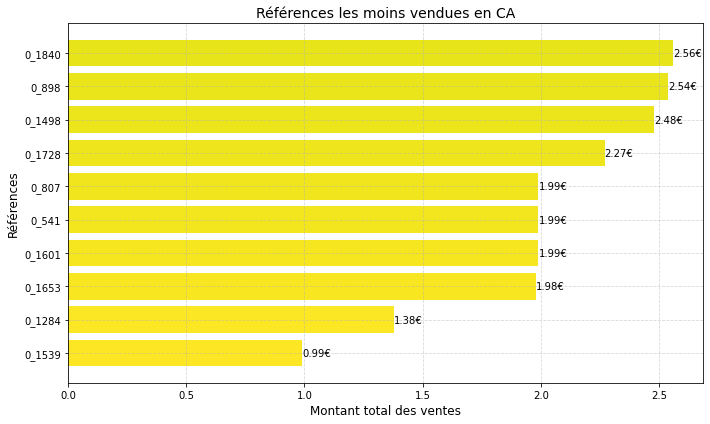

In [404]:
plt.figure(figsize=(10, 6))

# Tracer le graphique des références les moins vendues
bar_colors = plt.cm.get_cmap('viridis_r')(range(len(flop_references_sorted.index)))
plt.barh(flop_references_sorted.index, flop_references_sorted.values, color=bar_colors)

# Ajouter des étiquettes de valeur à droite de chaque barre (collées aux colonnes)
for i, value in enumerate(flop_references_sorted.values):
    plt.text(value, i, f"{value:.2f}€", va='center', ha='left')  # Utiliser ha='left' pour l'alignement horizontal à gauche

# Personnaliser l'apparence du graphique
plt.xlabel('Montant total des ventes', fontsize=12)
plt.ylabel('Références', fontsize=12)
plt.title('Références les moins vendues en CA', fontsize=14)
plt.xticks(fontsize=10)
plt.tight_layout()
# Ajout d'une grille
plt.grid(True, linestyle='--', alpha=0.5)
# Afficher le graphique
plt.show()

In [405]:
dft.head()

,id_prod,price,categ,date,session_id,client_id,sex,birth,age,tranche,profil,panier_moyen_par_age,panier_moyen_par_tranche_age,frequence_achat
0,0_1421,19.99,0,2021-03-01 04:13:00.107748,s_101,c_8533,m,1972,51,51-60,Homme entre 50-60 ans,13.370291,15.857667,51
1,0_1421,19.99,0,2021-03-01 13:48:20.214075,s_285,c_5299,f,1967,56,51-60,Femme entre 50-60 ans,16.806677,15.857667,62
2,0_1421,19.99,0,2021-03-01 15:07:42.730079,s_317,c_8024,f,1936,87,70+,Femme entre 70+ ans,16.850812,16.724476,105
3,0_1421,19.99,0,2021-03-02 03:39:21.811833,s_563,c_7702,f,1989,34,31-40,Femme entre 30-40 ans,13.370611,14.947460,94
4,0_1421,19.99,0,2021-03-02 19:09:41.789425,s_850,c_4057,m,1981,42,41-50,Homme entre 40-50 ans,13.352637,13.251897,243


## Répartition du CA par catégorie

In [406]:
# Répartition par catégorie
category_sales = dft.groupby('categ').sum()['price']
total_sales = category_sales.sum()

# Calculer la répartition en pourcentage
category_sales_percentage = (category_sales / total_sales) * 100

# Trier les catégories par ordre de grandeur
category_sales_percentage_sorted = category_sales_percentage.sort_values(ascending=True)

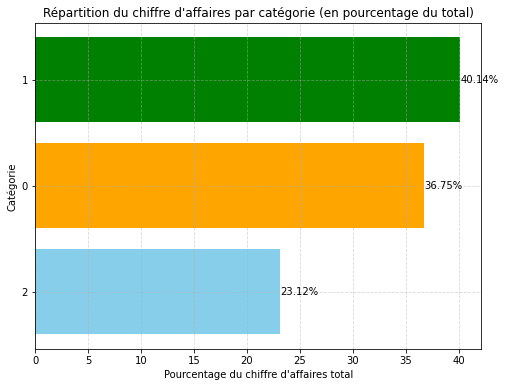

In [407]:
plt.figure(figsize=(8, 6))

# Tracer le graphique de la répartition par catégorie en pourcentage
plt.barh(category_sales_percentage_sorted.index, category_sales_percentage_sorted.values)  # Utilisation de barh pour les barres horizontales
plt.xlabel('Pourcentage du chiffre d\'affaires total')
plt.ylabel('Catégorie')
plt.title('Répartition du chiffre d\'affaires par catégorie (en pourcentage du total)')

# Couleurs pour chaque catégorie
colors = ['skyblue', 'orange', 'green']
# Tracer le graphique de la répartition par catégorie en pourcentage
plt.barh(category_sales_percentage_sorted.index, category_sales_percentage_sorted.values, color=colors)  # Utilisation de barh pour les barres horizontales

# Ajouter des étiquettes de pourcentage à droite de chaque barre
for i, value in enumerate(category_sales_percentage_sorted.values):
    plt.text(value, i, f"{value:.2f}%", ha='left', va='center')
# Ajout d'une grille
plt.grid(True, linestyle='--', alpha=0.5)
# Afficher le graphique
plt.show()

On remarque que 76% de notre CA vient des catégories 0 et 1.

## info sur les profils de nos clients

### Etude sur la répartition de nos clients en focntion du sexe

In [408]:
# Compter le nombre de clients dans chaque sexe
age_counts = dft['sex'].value_counts()

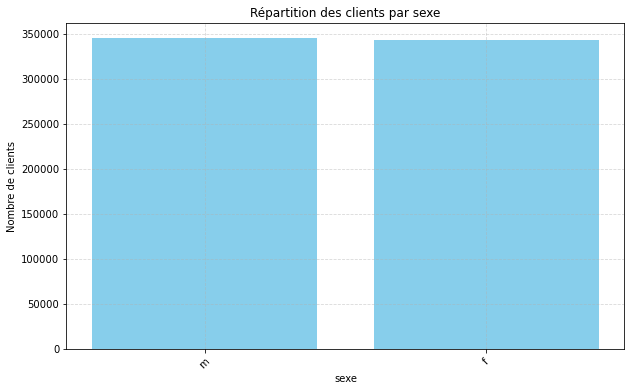

In [409]:
# Créer le graphique en barres
plt.figure(figsize=(10, 6))
plt.bar(age_counts.index, age_counts.values, color='skyblue')
plt.xlabel('sexe')
plt.ylabel('Nombre de clients')
plt.title('Répartition des clients par sexe')
plt.xticks(rotation=45)

# Ajout d'une grille
plt.grid(True, linestyle='--', alpha=0.5)

# Afficher le graphique
plt.show()

On remarque que le nombre de femmes et d'hommes dans nos client est relativeemtn égal.

### Etude sur la répartition de nos clients en focntion de la tranche d'age

In [410]:
# Compter le nombre de clients dans chaque tranche d'âge
age_counts = dft['tranche'].value_counts()

# Trier les tranches d'âge par ordre croissant pour le graphique
age_counts = age_counts.sort_index()

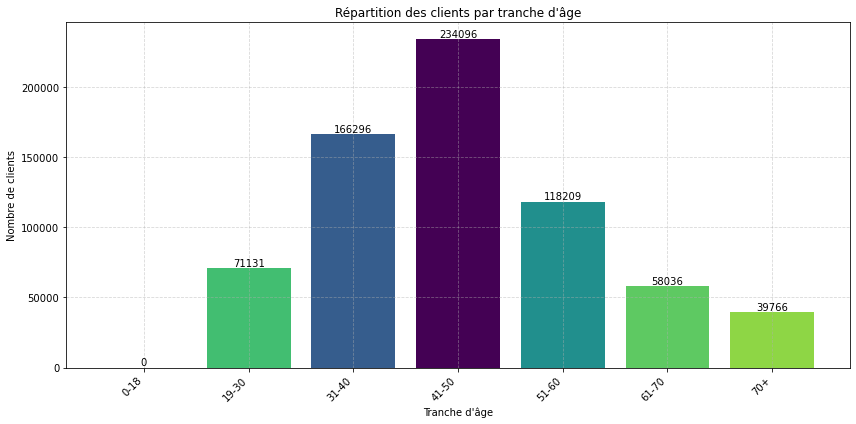

In [411]:
# Normaliser les valeurs pour la mise à l'échelle des couleurs
norm = plt.Normalize(age_counts.values.min(), age_counts.values.max())

# Choisir une carte de couleurs
cmap = plt.cm.viridis_r

# Créer le graphique en barres
plt.figure(figsize=(12, 6))
bars = plt.bar(age_counts.index, age_counts.values, color=[cmap(norm(value)) for value in age_counts.values])

plt.xlabel('Tranche d\'âge')
plt.ylabel('Nombre de clients')
plt.title('Répartition des clients par tranche d\'âge')
plt.xticks(rotation=45, ha='right')

# Ajouter les valeurs au-dessus des barres
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom')

# Ajout d'une grille
plt.grid(True, linestyle='--', alpha=0.5)

# Ajuster les marges pour assurer que les étiquettes s'ajustent bien
plt.tight_layout()

# Afficher le graphique
plt.show()


Maintenant que l'on sait que la majorité de nos clients ont entre 31 et 60 ans, avce une plus forte concentration dans la fourchette 41-50 regardont la répartition par porfil.

### Répartition des clients par âge

In [412]:
# Compter le nombre de clients dans chaque âge
age_counts = dft['age'].value_counts()

# Trier les âges par ordre croissant pour le graphique
age_counts = age_counts.sort_index()

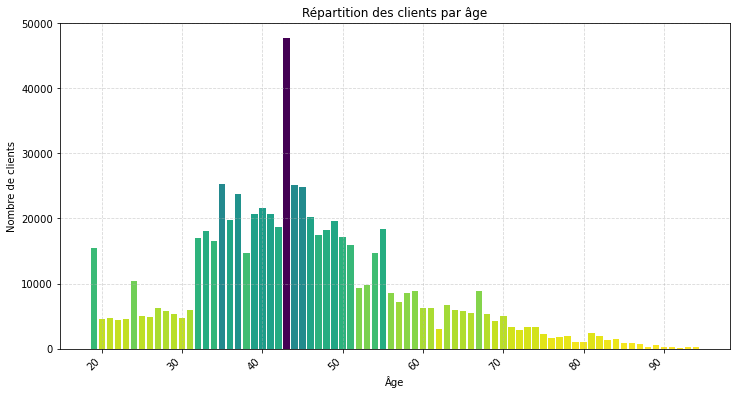

In [413]:
# Normaliser les valeurs pour la mise à l'échelle des couleurs
norm = plt.Normalize(age_counts.values.min(), age_counts.values.max())

# Choisir une carte de couleurs
cmap = plt.cm.viridis_r

# Créer le graphique en barres
plt.figure(figsize=(12, 6))

# Créer chaque barre individuellement et définir sa couleur en fonction de sa hauteur
for age, count in age_counts.iteritems():
    plt.bar(age, count, color=cmap(norm(count)))

plt.xlabel('Âge')
plt.ylabel('Nombre de clients')
plt.title('Répartition des clients par âge')
plt.xticks(rotation=45, ha='right') # Ajuster l'angle de rotation et l'alignement

# Ajout d'une grille
plt.grid(True, linestyle='--', alpha=0.5)

# Afficher le graphique
plt.show()

La majorité de nos clients ont entre 32 et 55 ans.

### Etude sur la répartition de nos clients en focntion du profil

In [414]:
# Compter le nombre de clients dans chaque profil
age_counts = dft['profil'].value_counts()

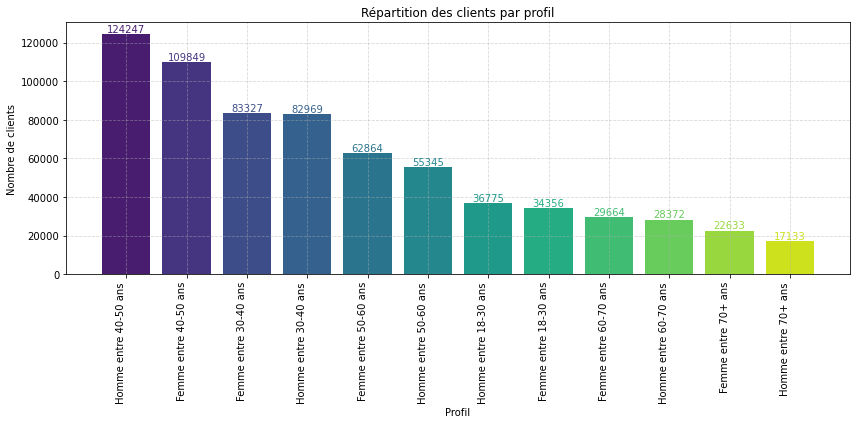

In [415]:
# Créer une palette de couleurs
colors = sns.color_palette('viridis', n_colors=len(age_counts))

# Créer le graphique en barres
plt.figure(figsize=(12, 6)) # Vous pouvez ajuster la taille du graphique
bars = plt.bar(age_counts.index, age_counts.values, color=colors)
plt.xlabel('Profil')
plt.ylabel('Nombre de clients')
plt.title('Répartition des clients par profil')
plt.xticks(rotation=90, ha='right') # Ajuster l'angle de rotation et l'alignement

# Ajout d'une grille
plt.grid(True, linestyle='--', alpha=0.5)

# Ajouter les valeurs au-dessus des barres
for bar, color in zip(bars, colors):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom', color=color)

# Ajuster les marges pour assurer que les étiquettes s'ajustent bien
plt.tight_layout()

# Afficher le graphique
plt.show()


On voit que le profil le plus réprésenté est celui des hommes entre 41 et 50 ans, Suivi pas les femmes du même âge. Regardons maintenant la répartition hommes femmes de notre populayion

## Répartition du CA par clients

### Calcul du CA par profil

In [416]:
# Calcul du chiffre d'affaires par profil client
profit_vente = dft.groupby('profil')['price'].sum()
total_vente = profit_vente.sum()

# Calcul de la répartition en pourcentage
profit_vente_pourcentage = (profit_vente / total_vente) * 100

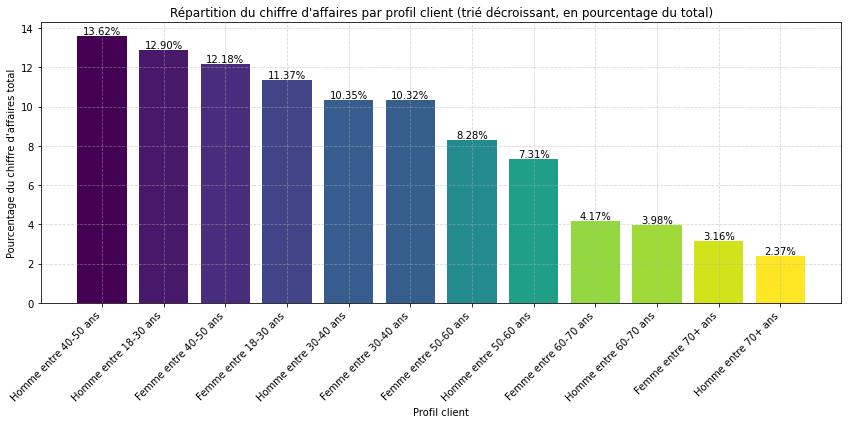

In [417]:
# Trier le DataFrame dans l'ordre décroissant
profit_vente_pourcentage_trie = profit_vente_pourcentage.sort_values(ascending=False)

# Choisir une carte de couleurs
cmap = plt.cm.viridis_r

# Normaliser les valeurs pour qu'elles se situent entre 0 et 1
norm = plt.Normalize(vmin=profit_vente_pourcentage_trie.min(), vmax=profit_vente_pourcentage_trie.max())

# Affichage du diagramme à barres trié en pourcentage
plt.figure(figsize=(12, 6))
bars = plt.bar(profit_vente_pourcentage_trie.index, profit_vente_pourcentage_trie.values, color=[cmap(norm(value)) for value in profit_vente_pourcentage_trie.values])
plt.xlabel('Profil client')
plt.ylabel('Pourcentage du chiffre d\'affaires total')
plt.title('Répartition du chiffre d\'affaires par profil client (trié décroissant, en pourcentage du total)')
plt.xticks(rotation=45, ha='right')

# Ajouter des étiquettes de pourcentage au-dessus de chaque barre
for bar, value in zip(bars, profit_vente_pourcentage_trie.values):
    plt.annotate(f"{value:.2f}%", (bar.get_x() + bar.get_width() / 2, value), ha='center', va='bottom')

# Ajout d'une grille
plt.grid(True, linestyle='--', alpha=0.5)

# Ajuster les marges pour assurer que les étiquettes s'ajustent bien
plt.tight_layout()

# Afficher le graphique
plt.show()


## Courbe de lorenz

La courbe de Lorenz est tracée en utilisant deux axes : l'axe horizontal représente le pourcentage cumulé des individus dans la population, tandis que l'axe vertical représente le pourcentage cumulé de la variable mesurée (par exemple, le chiffre d'affaires, le revenu, etc.).

In [418]:
dft.head()

,id_prod,price,categ,date,session_id,client_id,sex,birth,age,tranche,profil,panier_moyen_par_age,panier_moyen_par_tranche_age,frequence_achat
0,0_1421,19.99,0,2021-03-01 04:13:00.107748,s_101,c_8533,m,1972,51,51-60,Homme entre 50-60 ans,13.370291,15.857667,51
1,0_1421,19.99,0,2021-03-01 13:48:20.214075,s_285,c_5299,f,1967,56,51-60,Femme entre 50-60 ans,16.806677,15.857667,62
2,0_1421,19.99,0,2021-03-01 15:07:42.730079,s_317,c_8024,f,1936,87,70+,Femme entre 70+ ans,16.850812,16.724476,105
3,0_1421,19.99,0,2021-03-02 03:39:21.811833,s_563,c_7702,f,1989,34,31-40,Femme entre 30-40 ans,13.370611,14.947460,94
4,0_1421,19.99,0,2021-03-02 19:09:41.789425,s_850,c_4057,m,1981,42,41-50,Homme entre 40-50 ans,13.352637,13.251897,243


In [419]:
# Calculer le chiffre d'affaires total par profil client
ca_profil = dft.groupby('profil')['price'].sum()

# Calculer le pourcentage de chiffre d'affaires réalisé par chaque profil client
profit_vente_pourcentage = (ca_profil / ca_profil.sum()) * 100

# Trier les profils clients en fonction du chiffre d'affaires
profil_trie = profit_vente_pourcentage.sort_values(ascending=True) # changer le tri ?

# Calculer les pourcentages cumulés du chiffre d'affaires
pourcentage_cumule_ca = np.cumsum(profil_trie)

# Calculer les pourcentages cumulés de la population
population_cumule = np.arange(1, len(profil_trie) + 1) / len(profil_trie)

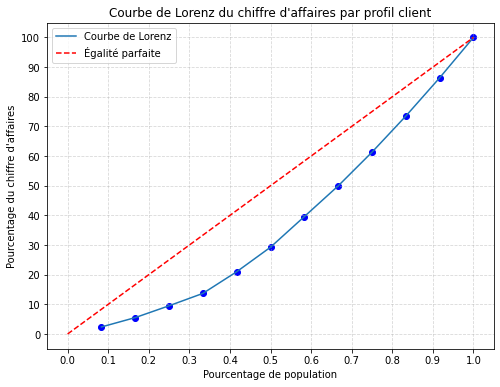

In [420]:
# Tracer la courbe de Lorenz avec la grille et les valeurs d'en-têtes
plt.figure(figsize=(8, 6))

# Tracer la courbe de Lorenz
plt.plot(population_cumule, pourcentage_cumule_ca, label='Courbe de Lorenz')

# Ajouter les points sur la courbe de Lorenz
plt.scatter(population_cumule, pourcentage_cumule_ca, color='blue')

plt.plot([0, 1], [0, 100], color='red', linestyle='--', label='Égalité parfaite')

plt.xlabel('Pourcentage de population')
plt.ylabel('Pourcentage du chiffre d\'affaires')
plt.title('Courbe de Lorenz du chiffre d\'affaires par profil client')
plt.legend()
# Ajout d'une grille
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(np.arange(0, 1.1, 0.1))  # Définir les étiquettes de l'axe x
plt.yticks(np.arange(0, 101, 10))  # Définir les étiquettes de l'axe y

plt.show()

On remarque que 50% de notre population représente 70% de notre CA.

In [421]:
# Calculer l'aire sous la courbe de Lorenz en utilisant la méthode des trapèzes
aire_courbe_de_lorenz = np.trapz(pourcentage_cumule_ca, population_cumule).round()

# Afficher l'aire sous la courbe de Lorenz
print("Aire sous la courbe de Lorenz:", aire_courbe_de_lorenz)

Aire sous la courbe de Lorenz: 37.0


L'aire sous la courbe de Lorenz représente la proportion de la totalité de la distribution (dans ce cas, le CA) détenue par une proportion donnée de la population (les clients). Une aire de 37.0 indique que la distribution est fortement inégale, avec une grande proportion du CA provenant d'une petite proportion de la population.

In [422]:
# Calculer l'aire totale sous la ligne d'égalité parfaite (A)
A = 0.5

# Calculer l'aire entre la courbe de Lorenz et la ligne d'égalité parfaite (B)
B = aire_courbe_de_lorenz - A

# Calculer l'indice de Gini (G)
gini_index = B / A

# Afficher l'indice de Gini
print("Indice de Gini:", gini_index)

Indice de Gini: 73.0


Indice de Gini: 73.0
L'indice de Gini est une mesure de l'inégalité qui varie entre 0 et 100. Un indice de 0 représente une distribution parfaitement équitable (chaque client contribue de manière égale au CA), tandis qu'un indice de 100 représente une inégalité totale (tout le CA provient d'un seul client).

Un indice de Gini de 73.0 est considéré comme très élevé et indique une inégalité importante dans la distribution du CA parmi vos clients. Cela signifie que la majorité du CA est générée par une petite proportion de vos clients.



Conclusion
Ces valeurs indiquent que votre entreprise dépend fortement d'un petit segment de clients pour générer la majorité de son chiffre d'affaires

<a id="section5"></a>
# **CORRELATIONS**
---

## le lien entre le genre d'un client et les catégories de livres achetées

In [423]:
# Grouper les données par 'sex' et 'categ', puis compter le nombre de produits dans chaque groupe
nombre_par_categorie = dft.groupby(['sex', 'categ']).count()['id_prod']

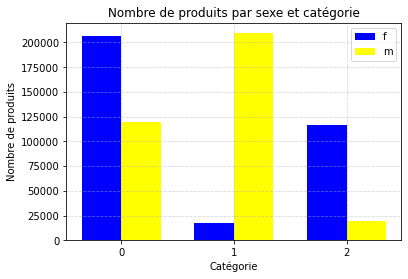

In [424]:
sexes =['f', 'm']
categories = ['0','1','2']

# Couleurs pour les hommes et les femmes
colors = ['blue', 'yellow']

# Configuration du graphique
x = range(len(categories))
width = 0.35

# Création du graphique à barres
fig, ax = plt.subplots()
for i, sex in enumerate(sexes):
    ax.bar([val + i * width for val in x], nombre_par_categorie[i::len(sexes)], width, label=sex, color=colors[i])

# Paramètres du graphique
ax.set_xlabel('Catégorie')
ax.set_ylabel('Nombre de produits')
ax.set_title('Nombre de produits par sexe et catégorie')
ax.set_xticks([val + width / 2 for val in x])
ax.set_xticklabels(categories)
ax.legend()
# Ajout d'une grille
plt.grid(True, linestyle='--', alpha=0.5)
# Affichage du graphique
plt.show()

On remarque que selon les catégories le nombre de produtis acheté par les clietns selon leur sexe varie enormément. On peut penser que la catégorie 1 est plus préféré cehz les hommes et l'inverse pour la catégorie 2. Pour la Catégorie 0 on a une forte présence des hommes mais aussi une forte présence des femmes mais moindre.

On choisit d'utiliser le test du Chi-carré car nous avons deux variables catégorielles. on ne peut donc pas utiliser une corrélation classiques.

In [425]:
# Création d'un tableau de contingence
contingency_table = pd.crosstab(dft['sex'], dft['categ'])

# Application du test du Chi-carré
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Afficher les résultats
print('Tableau de contingence :')
print(contingency_table)
print()
print('Résultats du test du Chi-carré :')
print()
print('Valeur de Chi2 :', chi2)
print()
print('P-valeur :', p)
print()
print('Degrés de liberté :', dof)
print()
print('Tableau des fréquences attendues :')
expected_table = pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns)
expected_table = expected_table.round() 
print(expected_table)

Tableau de contingence :
categ       0       1      2
sex                         
f      206103  119307  17283
m      209356  116285  19200

Résultats du test du Chi-carré :

Valeur de Chi2 : 158.25417617304882

P-valeur : 4.320582228399707e-35

Degrés de liberté : 2

Tableau des fréquences attendues :
categ         0         1        2
sex                               
f      207081.0  117428.0  18185.0
m      208378.0  118164.0  18298.0



Percentage Difference Table:


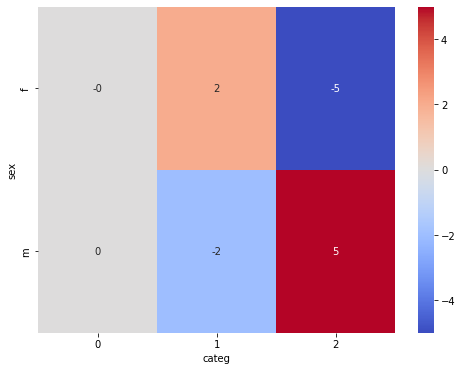

In [426]:
# Calcul de la différence entre les deux tables
difference_table = contingency_table - expected_table

# Calcul du pourcentage de la différnce
percentage_difference_table = round((difference_table / expected_table) * 100)

print("\nPercentage Difference Table:")

# Creation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(percentage_difference_table, annot=True, cmap='coolwarm')
plt.show()

Ces résultats indiquent que le test du Chi-carré a trouvé une association statistiquement significative entre le sexe du client et la catégorie de produits qu'ils achètent.

La valeur de Chi2 est assez élevée, ce qui indique une forte déviation par rapport à ce que nous attendrions si les deux variables étaient indépendantes. De plus, la p-valeur est extrêmement petite (bien en dessous du seuil standard de 0,05), ce qui signifie que le résultat est très probablement statistiquement significatif et non dû au hasard.

En conclusion, sur la base de ces résultats, il semble qu'il existe une corrélation entre le sexe d'un client et la catégorie de produits qu'il achète. Cependant, cela ne signifie pas nécessairement qu'il y a une relation de cause à effet. D'autres facteurs pourraient être à l'œuvre. (age, revenu,...)

## le lien entre l'âge des clients et le montant total des achats

In [427]:
# Grouper les données par âge et calculer la somme du montant total des achats
age_total_purchase = dft.groupby('age')['price'].sum()

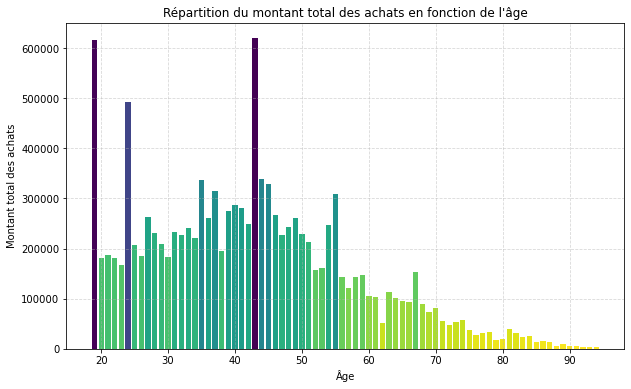

In [428]:
# Obtenir les valeurs d'âge et les montants totaux des achats
ages = age_total_purchase.index
purchase_totals = age_total_purchase.values

# Normaliser les valeurs d'achat pour la mise à l'échelle des couleurs
norm = plt.Normalize(purchase_totals.min(), purchase_totals.max())

# Choisir une carte de couleurs
cmap = plt.cm.viridis_r

# Créer le graphique à barres
plt.figure(figsize=(10, 6))
plt.bar(ages, purchase_totals, color=[cmap(norm(value)) for value in purchase_totals])
plt.xlabel('Âge')
plt.ylabel('Montant total des achats')
plt.title('Répartition du montant total des achats en fonction de l\'âge')

# Ajouter une grille
plt.grid(True, linestyle='--', alpha=0.5)

# Afficher le graphique
plt.show()

On remarque que nous avons beaucoup de personnes de 43 ans qui effectue des achats, ce qui correspond à notre tranche d'age la plus active. Cependant on remarque aussi que beaucoup de personnes de 18 ans effectue des achats. Cela est plus surprenant mais peut s'expliquer par le fait de posséder une carte bleu ou d'être majeur poiur ouvrir un compte client. Donc les mineurs doivent renseigner 18 ans pour pouvoir acheter un produit.

Nosu allons utiliser le coefficient de corrélation de Pearson qui est le plus adpaté pour deux variables continues. il mesure la force et la direction de la relation linéaire entre les variables.

In [429]:
# Calculer la corrélation et la p-valeur du montant total des achats en fonction de l'age
corr, p_value = pearsonr(dft['age'], dft['price'])
print('Correlation: ', corr)
print()
print('P-value: ', p_value)

Correlation:  -0.2074960877881335

P-value:  0.0


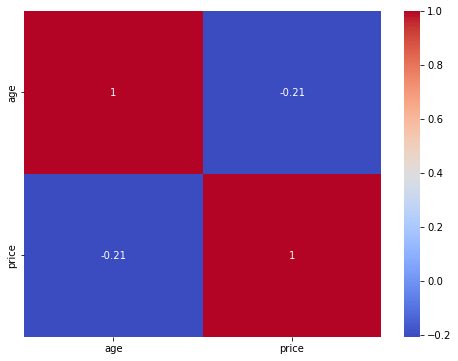

In [430]:
# corrélation entre l'age et le prix 
corr = dft[['age','price']].corr()

# Creation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

La corrélation entre l'âge des clients et le montant total des achats est de -0.20749608778813317, ce qui indique une corrélation négative faible. Le p-value est de 0.0, ce qui suggère que cette corrélation est statistiquement significative. Cela signifie qu'il existe une relation significative entre l'âge des clients et le montant total des achats, mais la corrélation est faible.

Veuillez noter que cette corrélation ne capture qu'une relation linéaire entre les deux variables et d'autres facteurs peuvent également influencer le montant total des achats. Il peut être utile d'explorer d'autres techniques d'analyse pour mieux comprendre la relation entre ces variables.

## le lien entre l'age des clients et la fréquence d'achat

In [431]:
# Grouper les données par âge et compter le nombre d'achats dans chaque groupe
achat_par_age = dft.groupby('age').count()['id_prod']

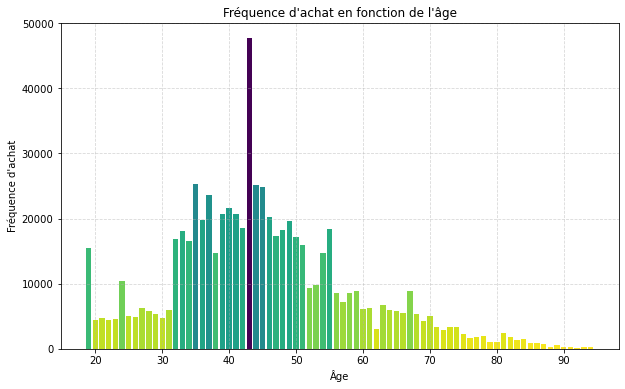

In [432]:
# Normaliser les valeurs de fréquence d'achat pour la mise à l'échelle des couleurs
norm = plt.Normalize(achat_par_age.values.min(), achat_par_age.values.max())

# Choisir une carte de couleurs
cmap = plt.cm.viridis_r

# Créer le graphique à barres
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(achat_par_age.index, achat_par_age.values, color=[cmap(norm(value)) for value in achat_par_age.values])

# Paramètres du graphique
ax.set_xlabel('Âge')
ax.set_ylabel('Fréquence d\'achat')
ax.set_title('Fréquence d\'achat en fonction de l\'âge')

# Ajouter une grille
ax.grid(True, linestyle='--', alpha=0.5)

# Affichage du graphique
plt.show()


On retrouve les personnes de 43 ans qui sont les plus présentes dans nos statistique en termes d'aceht et de présence. De 31 à 55 est la tranche d'age la plus active en terle de fréquence d'achat.

Nosu allons utiliser le coefficient de corrélation de Pearson qui est le plus adpaté pour deux variables continues. il mesure la force et la direction de la relation linéaire entre les variables.

In [433]:
# Calculer la corrélation et la p-valeur de la fréquence d'achat en fonction de l'age
corr, p_value = pearsonr(dft['age'], dft['frequence_achat'])
print('Correlation: ', corr)
print()
print('P-value: ', p_value)

Correlation:  -0.018499587076115064

P-value:  4.0869183211063767e-53


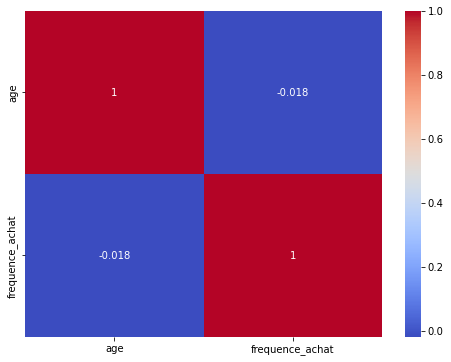

In [434]:
# corrélation avec la fonction pandas
corr = dft[['age','frequence_achat']].corr()

# Creation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

La corrélation de Pearson entre l'âge des clients et la fréquence d'achat est de -0.0185, ce qui indique une faible corrélation entre l'âge et la fréquence d'acaht des cleitns. La p-valeur associée est très faible (4.09e-53), ce qui suggère une corrélation significative entre l'age et la fréquence d'achat.

## le lien entre l'age du client et la taille du panier moyen

### Par tranche d'ages

In [435]:
# Grouper les données par âge et calculer la taille moyenne du panier
panier_moyen_par_tranche = dft.groupby('tranche')['panier_moyen_par_age'].mean()

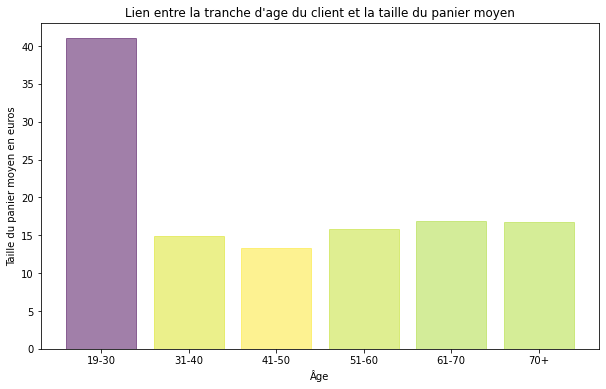

In [436]:
# Obtenir les valeurs minimales et maximales
min_value = panier_moyen_par_tranche.min()
max_value = panier_moyen_par_tranche.max()

# Créer un diagramme à barres
plt.figure(figsize=(10, 6))
bars = plt.bar(panier_moyen_par_tranche.index, panier_moyen_par_tranche.values, alpha=0.5)

# Appliquer la couleur en fonction de la hauteur des barres
for bar, value in zip(bars, panier_moyen_par_tranche.values):
    bar.set_color(plt.cm.viridis_r((value - min_value) / (max_value - min_value)))

plt.xlabel('Âge')
plt.ylabel('Taille du panier moyen en euros')
plt.title('Lien entre la tranche d\'age du client et la taille du panier moyen')

plt.show()

### Par age

In [437]:
# Grouper les données par âge et calculer la taille moyenne du panier
panier_moyen_par_age = dft.groupby('age')['panier_moyen_par_age'].mean()

In [438]:
dft['panier_moyen_par_age'].mean()

17.493917537183073

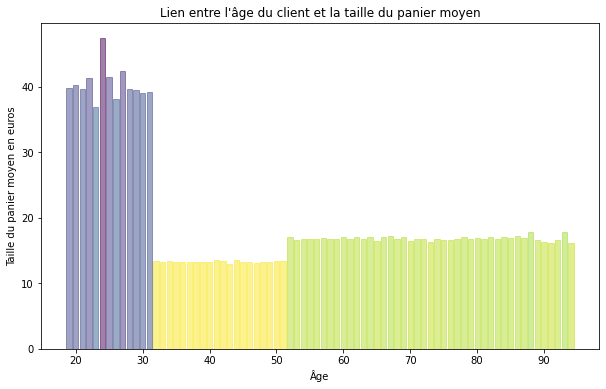

In [439]:
# Obtenir les valeurs minimales et maximales
min_value = panier_moyen_par_age.min()
max_value = panier_moyen_par_age.max()

# Créer un diagramme à barres
plt.figure(figsize=(10, 6))
bars = plt.bar(panier_moyen_par_age.index, panier_moyen_par_age.values, alpha=0.5)

# Appliquer la couleur en fonction de la hauteur des barres
for bar, value in zip(bars, panier_moyen_par_age.values):
    bar.set_color(plt.cm.viridis_r((value - min_value) / (max_value - min_value)))

plt.xlabel('Âge')
plt.ylabel('Taille du panier moyen en euros')
plt.title('Lien entre l\'âge du client et la taille du panier moyen')

plt.show()

On remarque que les personnes entre 18 et 31 ans ont un panier moyen largement supérieur au reste de notre population.

### Corrélations

Nosu allons utiliser le coefficient de corrélation de Pearson qui est le plus adpaté pour deux variables continues. il mesure la force et la direction de la relation linéaire entre les variables.

In [440]:
# Calculer la corrélation et la p-valeur entre la taille du panier moyen et l'age
corr, p_value = pearsonr(dft['age'], dft['panier_moyen_par_age'])
print('Correlation: ', corr)
print()
print('P-value: ', p_value)

Correlation:  -0.43263874261795243

P-value:  0.0


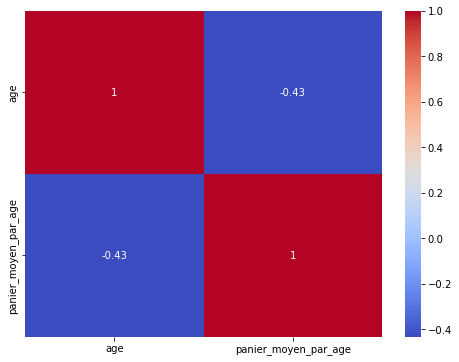

In [441]:
# calcul corrélation
corr = dft[['age','panier_moyen_par_age']].corr()

# Creation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

La corrélation entre l'âge du client et la taille du panier moyen est de -0.4326, la corrélation est modérée, ce qui suggère qu'il existe une tendance à une diminution de la taille du panier moyen avec l'augmentation de l'âge. La p-valeur est de 0.0, ce qui suggère que cette corrélation est statistiquement significative. Cela signifie qu'il existe une relation significative entre l'âge du client et la taille de son panier moyen.

## le lien entre l'age et la catégorie de livre achetés

2 approches au problème, une avec els tranches d'ages et l'autre avec l'age.

### Lien entre la tranche d'age et la catégorie de livre achetés

#### Répartition du nombre de produits de la catégorie 0 en fonction de la tranche d'age

In [442]:
# Filtrer les données pour la catégorie 0
category_0 = dft[dft['categ'] == '0']

# Grouper les données par âge et compter le nombre de produits dans chaque groupe
category_0_counts = category_0.groupby('age')['id_prod'].count()

# Grouper les données par tranche d'âge et compter le nombre de produits dans chaque groupe
category_counts_tranche_0 = category_0.groupby('tranche')['id_prod'].count()
category_counts_tranche_0

tranche
0-18          0
19-30     14412
31-40    119972
41-50    177018
51-60     62257
61-70     24801
70+       16999
Name: id_prod, dtype: int64

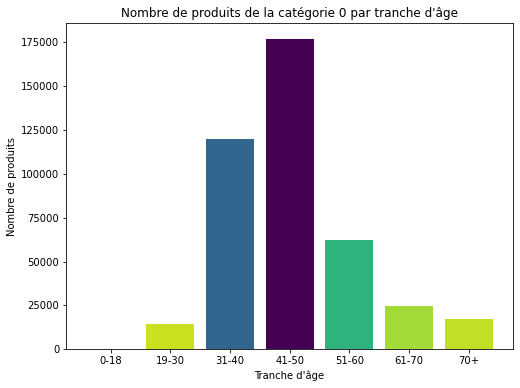

In [443]:
# Données pour les catégories d'âge et le nombre de produits
tranche = ['0-18', '19-30', '31-40', '41-50', '51-60', '61-70', '70+']
nombre_produits = [0, 14412, 119972, 177018, 62257, 24801, 16999]

# Normaliser les valeurs de nombre_produits
norm = plt.Normalize(min(nombre_produits), max(nombre_produits))

# Créer une palette de couleurs basée sur la normalisation
colors = [plt.cm.viridis_r(norm(value)) for value in nombre_produits]

# Créer le graphique à barres
plt.figure(figsize=(8, 6))
bars = plt.bar(tranche, nombre_produits, color=colors)

# Ajouter des étiquettes et des titres
plt.xlabel('Tranche d\'âge')
plt.ylabel('Nombre de produits')
plt.title('Nombre de produits de la catégorie 0 par tranche d\'âge')

# Afficher le graphique
plt.show()

Les 31-50 ans sont ceux qui achète le plus de la catégorie 0

#### Répartition du nombre de produits de la catégorie 1 en fonction de la tranche d'age

In [444]:
# Filtrer les données pour la catégorie 1
category_1 = dft[dft['categ'] == '1']

# Grouper les données par âge et compter le nombre de produits dans chaque groupe
category_1_counts = category_1.groupby('age')['id_prod'].count()

# Grouper les données par tranche d'âge et compter le nombre de produits dans chaque groupe
category_counts_tranche_1 = category_1.groupby('tranche')['id_prod'].count()
category_counts_tranche_1

tranche
0-18         0
19-30    27656
31-40    41628
41-50    56309
51-60    54896
61-70    32685
70+      22418
Name: id_prod, dtype: int64

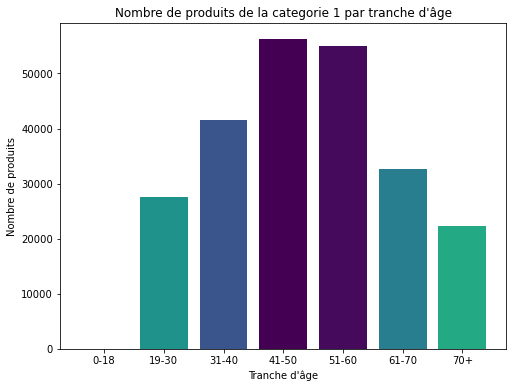

In [445]:
# Données pour les catégories d'âge et le nombre de produits
tranche = ['0-18', '19-30', '31-40', '41-50', '51-60', '61-70', '70+']
nombre_produits = [0, 27656, 41628, 56309, 54896, 32685, 22418]

# Normaliser les valeurs de nombre_produits
norm = plt.Normalize(min(nombre_produits), max(nombre_produits))

# Créer une palette de couleurs basée sur la normalisation
colors = [plt.cm.viridis_r(norm(value)) for value in nombre_produits]
# Créer le graphique à barres
plt.figure(figsize=(8, 6))
plt.bar(tranche, nombre_produits, color=colors)

# Ajouter des étiquettes et des titres
plt.xlabel('Tranche d\'âge')
plt.ylabel('Nombre de produits')
plt.title('Nombre de produits de la categorie 1 par tranche d\'âge')

# Afficher le graphique
plt.show()

Pour la catégorie 1 la répartition est plus équilibré entre les tranches d'ages malgré une plius importante présence des 41-60 ans dnas notre population.

#### Répartition du nombre de produits de la catégorie 2 en fonction de la tranche d'age

In [446]:
# Filtrer les données pour la catégorie 2
category_2 = dft[dft['categ'] == '2']

# Grouper les données par âge et compter le nombre de produits dans chaque groupe
category_2_counts = category_2.groupby('age')['id_prod'].count()

# Grouper les données par tranche d'âge et compter le nombre de produits dans chaque groupe
category_counts_tranche_2 = category_2.groupby('tranche')['id_prod'].count()
category_counts_tranche_2

tranche
0-18         0
19-30    29063
31-40     4696
41-50      769
51-60     1056
61-70      550
70+        349
Name: id_prod, dtype: int64

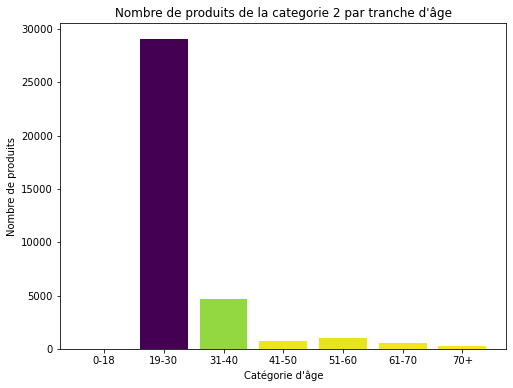

In [447]:
# Données pour les catégories d'âge et le nombre de produits
tranche = ['0-18', '19-30', '31-40', '41-50', '51-60', '61-70', '70+']
nombre_produits = [0, 29063, 4696, 769, 1056, 550, 349]

# Normaliser les valeurs de nombre_produits
norm = plt.Normalize(min(nombre_produits), max(nombre_produits))

# Créer une palette de couleurs basée sur la normalisation
colors = [plt.cm.viridis_r(norm(value)) for value in nombre_produits]

# Créer le graphique à barres
plt.figure(figsize=(8, 6))
plt.bar(tranche, nombre_produits, color=colors)

# Ajouter des étiquettes et des titres
plt.xlabel('Catégorie d\'âge')
plt.ylabel('Nombre de produits')
plt.title('Nombre de produits de la categorie 2 par tranche d\'âge')

# Afficher le graphique
plt.show()

Pour la catégorie 2 les 19-30 sont largement majoritaire.

### Lien entre l'age et la catégorie de livre achetés

#### Répartition du nombre de produits de la catégorie 0 en fonction de l'age

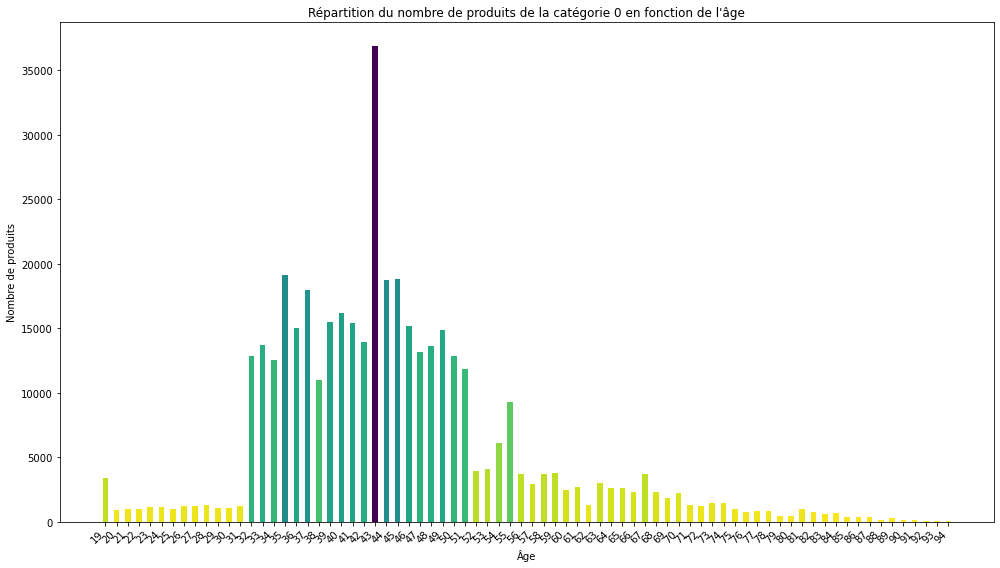

In [448]:
# Normaliser les valeurs de category_0_counts
norm = plt.Normalize(category_0_counts.min(), category_0_counts.max())

# Créer une palette de couleurs basée sur la normalisation
colors = [plt.cm.viridis_r(norm(value)) for value in category_0_counts]

# Créer les positions des âges sur l'axe x
x = np.arange(len(category_0_counts))

# Créer la figure et l'axe avec une taille agrandie
plt.figure(figsize=(14, 8))
ax = plt.gca()

# Créer les barres
ax.bar(x, category_0_counts, width=0.5, color=colors)

# Définir les étiquettes de l'axe x et le titre du graphique
ax.set_xticks(x)
ax.set_xticklabels(category_0_counts.index, rotation=45, ha='right')
ax.set_xlabel('Âge')
ax.set_ylabel('Nombre de produits')
ax.set_title('Répartition du nombre de produits de la catégorie 0 en fonction de l\'âge')

# Ajuster les marges pour éviter que les étiquettes ne soient coupées
plt.tight_layout()

# Afficher le graphique
plt.show()

#### Répartition du nombre de produits de la catégorie 1 en fonction de l'age

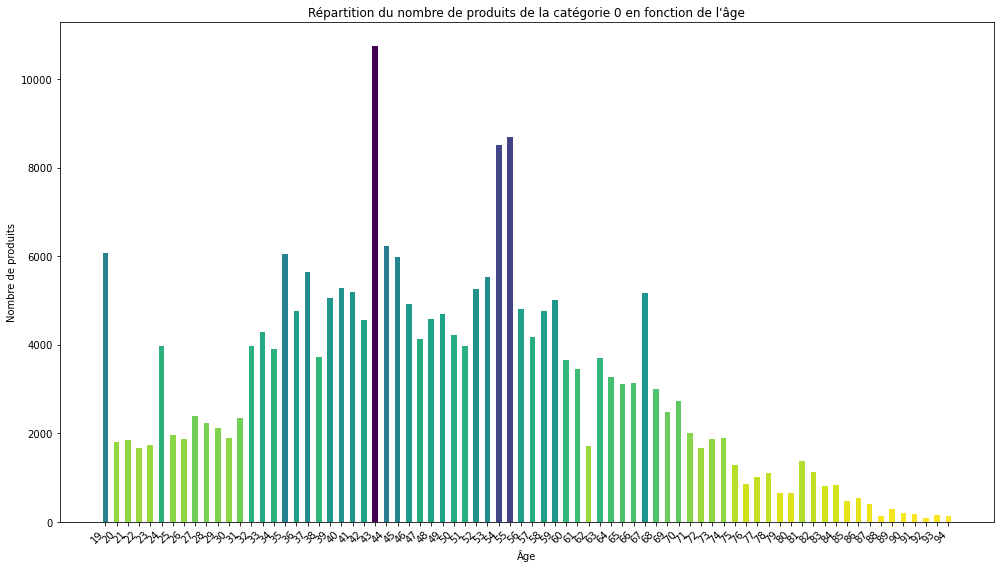

In [449]:
# Normaliser les valeurs de category_1_counts
norm = plt.Normalize(category_1_counts.min(), category_1_counts.max())

# Créer une palette de couleurs basée sur la normalisation
colors = [plt.cm.viridis_r(norm(value)) for value in category_1_counts]

# Créer les positions des âges sur l'axe x
x = np.arange(len(category_1_counts))

# Créer la figure et l'axe avec une taille agrandie
plt.figure(figsize=(14, 8))
ax = plt.gca()

# Créer les barres
ax.bar(x, category_1_counts, width=0.5, color=colors)

# Définir les étiquettes de l'axe x et le titre du graphique
ax.set_xticks(x)
ax.set_xticklabels(category_1_counts.index, rotation=45, ha='right')
ax.set_xlabel('Âge')
ax.set_ylabel('Nombre de produits')
ax.set_title('Répartition du nombre de produits de la catégorie 0 en fonction de l\'âge')

# Ajuster les marges pour éviter que les étiquettes ne soient coupées
plt.tight_layout()

# Afficher le graphique
plt.show()

#### Répartition du nombre de produits de la catégorie 2 en fonction de l'age

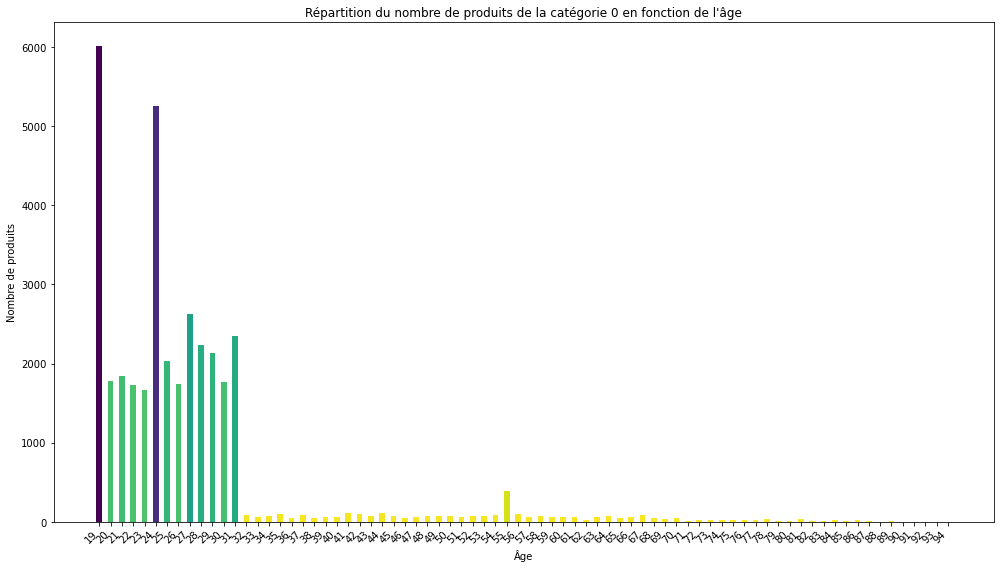

In [450]:
# Normaliser les valeurs de category_2_counts
norm = plt.Normalize(category_2_counts.min(), category_2_counts.max())

# Créer une palette de couleurs basée sur la normalisation
colors = [plt.cm.viridis_r(norm(value)) for value in category_2_counts]

# Créer les positions des âges sur l'axe x
x = np.arange(len(category_2_counts))

# Créer la figure et l'axe avec une taille agrandie
plt.figure(figsize=(14, 8))
ax = plt.gca()

# Créer les barres
ax.bar(x, category_2_counts, width=0.5, color=colors)

# Définir les étiquettes de l'axe x et le titre du graphique
ax.set_xticks(x)
ax.set_xticklabels(category_2_counts.index, rotation=45, ha='right')
ax.set_xlabel('Âge')
ax.set_ylabel('Nombre de produits')
ax.set_title('Répartition du nombre de produits de la catégorie 0 en fonction de l\'âge')

# Ajuster les marges pour éviter que les étiquettes ne soient coupées
plt.tight_layout()

# Afficher le graphique
plt.show()

### Test ANOVA

In [451]:
#  ANOVA test
anova_result = f_oneway(*[dft[dft['age'] == tr]['categ'] for tr in dft['age'].unique()])

# Afficher les résultats
print("ANOVA Test Results:")
print("F-statistic:", anova_result.statistic)
print("P-value:", anova_result.pvalue)

ANOVA Test Results:
F-statistic: 3489.842286029996
P-value: 0.0


la F-statistic est de 3489.842 et la P-value est de 0.0. Cela signifie qu'il existe des différences significatives entre les moyennes des groupes analysés et que ces différences ne sont pas dues au hasard. La P-value étant nulle, cela indique une très forte confiance statistique dans le rejet de l'hypothèse nulle selon laquelle les moyennes des groupes seraient égales. (l'hypothèse nulle est que les moyennes de tous les groupes sont égales) .

### Test du Chi-carré

Pour calculer la corrélation entre la tranche d'age et la categ on va utilsier le test du chi-carré, car ce sont 2 vairables catégorielles.

In [452]:
# Créer le tableau de contingence entre 'tranchr' et 'categ'
contingency_table = pd.crosstab(dft['tranche'], dft['categ'])

# Appliquer le test du Chi-carré
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Afficher les résultats
print('Tableau de contingence :')
print(contingency_table)
print()
print('Résultats du test du Chi-carré :')
print('Valeur de Chi2 :', chi2)
print('P-valeur :', p_value)
print('Degrés de liberté :', dof)
print()
print('Tableau des fréquences attendues :')
expected_table = pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns)
expected_table = expected_table.round()
print(expected_table)

Tableau de contingence :
categ         0      1      2
tranche                      
19-30     14412  27656  29063
31-40    119972  41628   4696
41-50    177018  56309    769
51-60     62257  54896   1056
61-70     24801  32685    550
70+       16999  22418    349

Résultats du test du Chi-carré :
Valeur de Chi2 : 258855.0985749726
P-valeur : 0.0
Degrés de liberté : 10

Tableau des fréquences attendues :
categ           0        1        2
tranche                            
19-30     42983.0  24374.0   3774.0
31-40    100488.0  56983.0   8824.0
41-50    141458.0  80216.0  12422.0
51-60     71431.0  40506.0   6273.0
61-70     35070.0  19887.0   3080.0
70+       24030.0  13626.0   2110.0



Percentage Difference Table:
categ       0     1      2
tranche                   
19-30   -66.0  13.0  670.0
31-40    19.0 -27.0  -47.0
41-50    25.0 -30.0  -94.0
51-60   -13.0  36.0  -83.0
61-70   -29.0  64.0  -82.0
70+     -29.0  65.0  -83.0


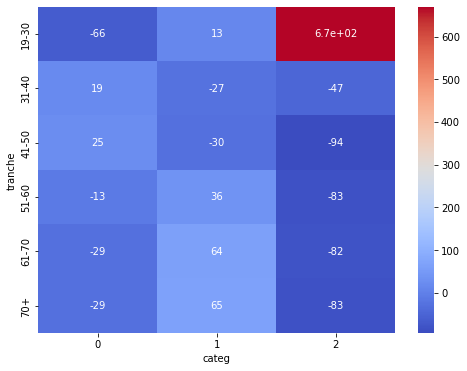

In [453]:
# Calcul de la différence entre les deux tables
difference_table = contingency_table - expected_table

# Calcul du pourcentage de la différnce
percentage_difference_table = round((difference_table / expected_table) * 100)

print("\nPercentage Difference Table:")
print(percentage_difference_table)

# Creation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(percentage_difference_table, annot=True, cmap='coolwarm')
plt.show()

Les résultats du test du Chi-carré indiquent une association statistiquement significative entre les variables "age" et "categ".

La valeur de Chi2 est élevée (305629.37802685937), ce qui suggère une forte déviation par rapport à ce que nous attendrions si les deux variables étaient indépendantes. La p-valeur est de zéro 0.0, ce qui indique que le résultat n'est pas du au hasard.

Le tableau de contingence montre le nombre d'observations pour chaque combinaison d'âge et de catégorie. Le tableau des fréquences attendues présente les fréquences théoriques attendues sous l'hypothèse nulle d'indépendance entre les variables.

Ces résultats suggèrent donc qu'il existe une relation significative entre l'âge et la catégorie de produits achetés. Cependant, il est important de noter que le test du Chi-carré mesure uniquement l'association entre les variables et ne fournit pas d'indication sur la direction ou la force de la relation. Pour obtenir des informations plus détaillées sur la nature de cette relation, il peut être utile d'utiliser d'autres mesures de corrélation adaptées aux variables catégorielles.

<a id="section6"></a>
# **CONCLUSION**
---

**Profil des Clients :**

Les clients ont été catégorisés en différents profils basés sur l'âge et le sexe.

Maintenant que l'on sait que la majorité de nos clients ont entre 31 et 60 ans, avce une plus forte concentration dans la fourchette 41-50 regardont la répartition par porfil.

On remarque que le nombre de femmes et d'hommes dans nos client est relativeemtn égal.

On remarque que nous avons beaucoup de personnes de 43 ans qui effectue des achats, ce qui correspond à notre tranche d'age la plus active. Cependant on remarque aussi que beaucoup de personnes de 18 ans effectue des achats. Cela est plus surprenant mais peut s'expliquer par le fait de posséder une carte bleu ou d'être majeur poiur ouvrir un compte client. Donc les mineurs doivent renseigner 18 ans pour pouvoir acheter un produit.

**Comportement d'Achat :**

L'étude a examiné la fréquence d'achat et la taille du panier moyen en fonction de l'âge.
On remarque que 76% de notre CA vient des catégories 0 et 1.

On remarque que selon les catégories le nombre de produtis acheté par les clietns selon leur sexe varie enormément. 

On peut penser que la catégorie 1 est plus préféré cehz les hommes et l'inverse pour la catégorie 2. 

Pour la Catégorie 0 on a une forte présence des hommes mais aussi une forte présence des femmes mais moindre.



**correlations :**
- Il existe une corrélation entre le sexe d'un client et la catégorie de produits qu'il achète.
- Il existe une relation significative entre l'âge des clients et le montant total des achats, mais la corrélation est faible.
- Il existe une faible corrélation entre l'âge et la fréquence d'achat des clients, mais la corrélation est faible.
- Il existe une relation significative entre l'âge du client et la taille de son panier moyen.
- Il existe une relation significative entre l'âge et la catégorie de produits achetés.

**Analyse des Catégories de Produits :**

En somme, cette étude a permis une compréhension approfondie du comportement des clients, de leurs préférences et de leurs tendances d'achat.
On remarque que les personnes entre 18 et 31 ans ont un panier moyen largement supérieur au reste de notre population.

On retrouve les personnes de 43 ans qui sont les plus présentes dans nos statistique en termes d'aceht et de présence. De 31 à 55 est la tranche d'age la plus active en terle de fréquence d'achat.

Les 31-50 ans sont ceux qui achète le plus de la catégorie 0
Pour la catégorie 1 la répartition est plus équilibré entre les tranches d'ages malgré une plius importante présence des 41-60 ans dnas notre population.
Pour la catégorie 2 les 19-35 sont largement majoritaire.

**Chiffre d'Affaires et Rentabilité :**

La répartition du chiffre d'affaires par profil client et par catégorie de produit a été étudiée.

Les 10 produits les plus vendus représentent 5.17% du chiffre d'affaires total.

On remarque que 50% de notre population représente 70% de notre CA.